<a href="https://colab.research.google.com/github/vatsal9876/image_restoration/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle tensorflow-addons
import os
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras import Model
from google.colab import files
import matplotlib.pyplot as plt
import random

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d badasstechie/celebahq-resized-256x256
!unzip -q celebahq-resized-256x256.zip -d celebahq-256


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256
License(s): GPL-2.0
celebahq-resized-256x256.zip: Skipping, found more recently modified local copy (use --force to force download)
replace celebahq-256/celeba_hq_256/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Masking and Corrupting the image

In [ ]:
def apply_random_mask(img, mask_ratio=0.3):
    h, w = img.shape[:2]
    mask_h, mask_w = int(h * mask_ratio), int(w * mask_ratio)

    top = random.randint(0, h - mask_h)
    left = random.randint(0, w - mask_w)

    masked_img = img.copy()
    masked_img[top:top+mask_h, left:left+mask_w] = 0

    return masked_img

In [ ]:
def add_gaussian_noise(img, mean=0, std=0.1):
    noise = np.random.normal(mean, std, img.shape).astype(np.float32)
    noisy = img + noise
    return np.clip(noisy, 0, 1)

In [ ]:
def blur_image(img, ksize=7):
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

In [ ]:
def random_corruption(img):
    corrupted = img.copy()

    if random.random() < 0.7:
        corrupted = add_gaussian_noise(corrupted, std=0.03)
    if random.random() < 0.8:
        corrupted = blur_image(corrupted, ksize=3)
    if random.random() < 0.5:
        corrupted = apply_random_mask(corrupted, mask_ratio=0.2)

    return np.clip(corrupted, 0, 1)

Data

In [ ]:
def process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    img = tf.cast(img, tf.float32) / 255.0

    def apply_corruptions(img_tensor):
        img_np = img_tensor.numpy()

        try:
            corrupted = random_corruption(img_np)
            clean = img_np.copy()
            return corrupted.astype(np.float32), clean.astype(np.float32)
        except Exception as e:
            print(f"Error in corruption: {e}")
            return np.zeros((64, 64, 3), dtype=np.float32), np.zeros((64, 64, 3), dtype=np.float32)

    corrupted, clean = tf.py_function(
        apply_corruptions,
        [img],
        (tf.float32, tf.float32)
    )

    corrupted.set_shape((64, 64, 3))
    clean.set_shape((64, 64, 3))

    return corrupted, clean

# Create dataset
dataset = tf.data.Dataset.list_files('/content/celebahq-256/celeba_hq_256/*.jpg')
dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


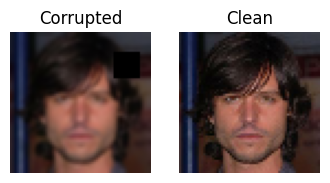

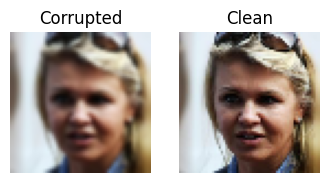

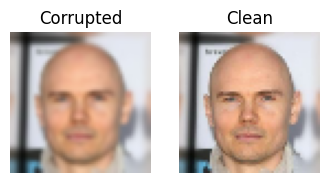

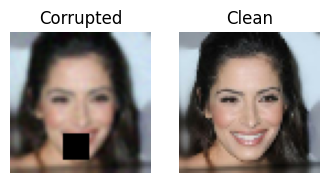

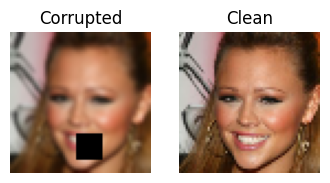

In [ ]:
import matplotlib.pyplot as plt

for corrupted, clean in dataset.take(1):
    for i in range(5):
        plt.figure(figsize=(4,2))

        plt.subplot(1, 2, 1)
        plt.imshow(corrupted[i].numpy())
        plt.title("Corrupted")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(clean[i].numpy())
        plt.title("Clean")
        plt.axis('off')

        plt.show()


In [ ]:
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

In [ ]:
latent_dim = 128
img_shape = (64, 64, 3)

def latent_sampling(z_args):
    z_mean, z_log_var = z_args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
def build_encoder(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return tf.keras.Model(inputs, [z_mean, z_log_var], name='encoder')


In [ ]:
def build_decoder():
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16*16*64, activation='relu')(decoder_input)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    decoded_output = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)
    return Model(decoder_input, decoded_output, name='decoder')

In [ ]:
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = latent_sampling([z_mean, z_log_var])
        return self.decoder(z)

    def compile(self, optimizer):
        super().compile(optimizer=optimizer,
                        loss=lambda y_true, y_pred: 0.0,
                        metrics=[])
        self.optimizer = optimizer

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        noisy, clean = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(noisy)
            z = latent_sampling([z_mean, z_log_var])
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_sum(
                  tf.square(clean - reconstruction)
            )


            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
encoder = build_encoder()
decoder = build_decoder()

vae = VAEModel(encoder,decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_vae.weights.h5',
    save_best_only=True,
    monitor='val_loss')

early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

history = vae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - kl_loss: 2.4863 - loss: 7138.4692 - reconstruction_loss: 7135.9785

750/750 ━━━━━━━━━━━━━━━━━━━━ 444s 571ms/step - kl_loss: 2.4869 - loss: 7137.9658 - reconstruction_loss: 7135.4746 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 416s 546ms/step - kl_loss: 3.4438 - loss: 6465.2412 - reconstruction_loss: 6461.7979 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 439s 542ms/step - kl_loss: 3.7002 - loss: 6392.9561 - reconstruction_loss: 6389.2554 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


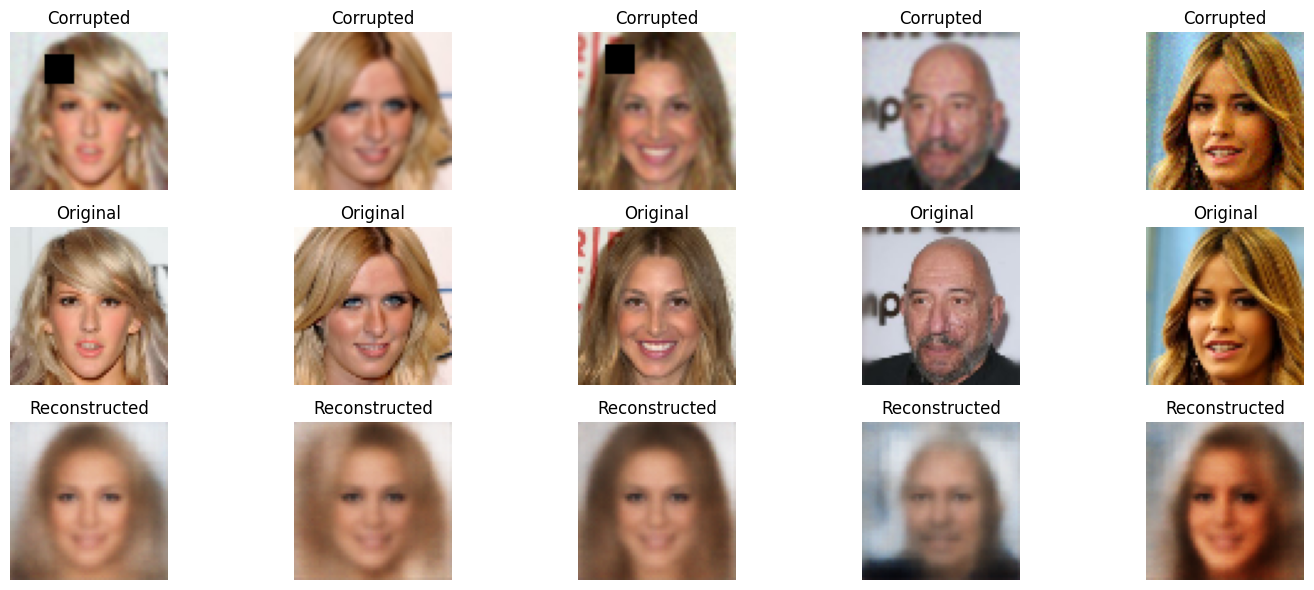

In [ ]:
def plot_samples(num_samples=5):
    test_batch = next(iter(val_ds))
    corrupted, clean = test_batch
    reconstructed = vae.predict(corrupted)

    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i+1)
        plt.imshow(corrupted[i])
        plt.title('Corrupted')
        plt.axis('off')

        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(clean[i])
        plt.title('Original')
        plt.axis('off')
        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(reconstructed[i])
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_samples()

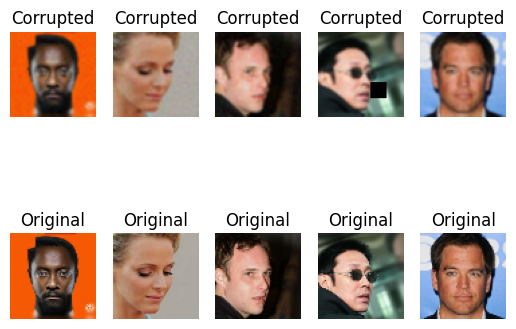

In [ ]:
import matplotlib.pyplot as plt

# Example: Plot 5 images from a batch
for corrupted, clean in train_ds.take(1):
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(corrupted[i].numpy())  # Corrupted image
        plt.title('Corrupted')
        plt.axis('off')
        plt.subplot(2, 5, i+6)
        plt.imshow(clean[i].numpy())      # Original image
        plt.title('Original')
        plt.axis('off')
    plt.show()
